# Prior Selection: From Optimization Bounds to Probability Distributions

This notebook demonstrates how to transform parameter bounds into appropriate Bayesian priors, validate prior choices through prior predictive checks, and assess prior sensitivity.

## Learning Objectives

After completing this notebook, you will be able to:
- Transform parameter bounds into appropriate prior distributions
- Distinguish between informative and weakly informative priors
- Use prior predictive checks to validate prior choices
- Understand prior sensitivity and when it matters
- Apply domain knowledge to constrain parameter space

## Prerequisites

- Bayesian inference basics (see `01-bayesian-basics.ipynb`)
- Understanding of probability distributions
- Familiarity with Maxwell model

**Estimated Time:** 30 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## 1. Introduction: From Bounds to Priors

### NLSQ Uses Hard Bounds

In optimization, we specify hard bounds:
```python
model.parameters.set_bounds('G0', (1e3, 1e9))  # G₀ ∈ [1e3, 1e9]
```

These bounds say: "G₀ can be anywhere in this range, equally likely."

### Bayesian Uses Probability Distributions

In Bayesian inference, we use **probability distributions** (priors):
```python
G0 ~ LogNormal(log(1e6), 2)  # G₀ most likely around 1e6, but flexible
```

Priors encode the **strength of belief**:
- Wide prior: Weak prior knowledge → data dominates
- Narrow prior: Strong prior knowledge → regularization

### Why Distributions Instead of Bounds?

1. **Regularization**: Prevents extreme parameter values
2. **Domain knowledge**: Incorporate known physical constraints
3. **Numerical stability**: Guides MCMC to reasonable regions
4. **Interpretability**: Explicit about prior beliefs

## 2. Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import warnings

import matplotlib
import matplotlib.pyplot as plt

# Standard imports
import numpy as np

# NumPyro for prior distributions
import numpyro
import numpyro.distributions as dist
from IPython.display import display
from numpyro.infer import Predictive

# Rheo imports
from rheojax.models import Maxwell
from scipy import stats

from rheojax.core.jax_config import safe_import_jax

# Safe JAX import
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plotting configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ Imports successful


## 3. Prior Types and When to Use Them

### Three Main Prior Types:

**1. Informative Priors**
- Strong domain knowledge (literature, previous experiments)
- Example: `G₀ ~ Normal(1e6, 1e5)` for specific polymer
- Use when: You have reliable prior information

**2. Weakly Informative Priors** (Recommended Default)
- Regularization without strong assumptions
- Example: `G₀ ~ LogNormal(log(1e6), 2)`
- Use when: Order of magnitude known, but not precise value
- Prevents extreme values while remaining flexible

**3. Flat (Uninformative) Priors**
- Maximum entropy, no prior knowledge
- Example: `G₀ ~ Uniform(1e3, 1e9)`
- Use when: Truly no prior knowledge (rare)
- Warning: Can lead to improper posteriors if bounds too wide

## 4. NumPyro Priors for Rheology

Common prior patterns for rheological parameters:

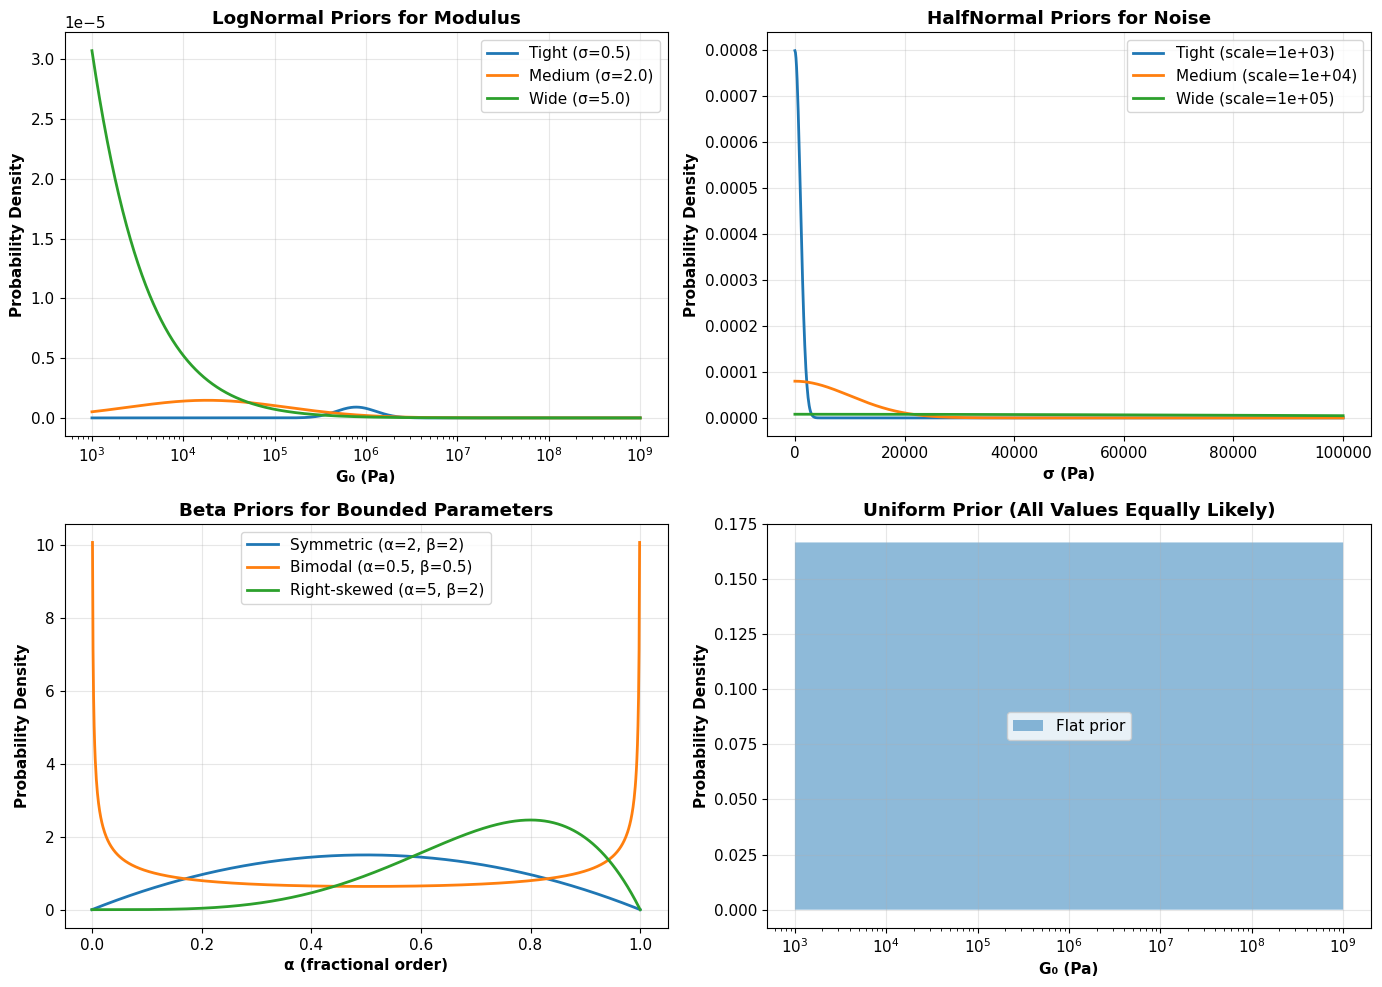


RECOMMENDATIONS FOR RHEOLOGY:
- Positive moduli (G₀, E, K): LogNormal(log(center), 2)
- Positive viscosity (η): LogNormal(log(center), 2)
- Noise parameters (σ): HalfNormal(scale)
- Bounded parameters (α ∈ [0,1]): Beta(2, 2) for symmetric
- Yield stress (τ_y > 0): Gamma(2, 0.01) or HalfNormal


In [3]:
# Visualize common prior distributions for rheology

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. LogNormal for positive moduli (log-scale appropriate)
G0_values = np.logspace(3, 9, 1000)
log_mean = np.log(1e6)
for scale_idx, (scale, label) in enumerate([(0.5, 'Tight'), (2.0, 'Medium'), (5.0, 'Wide')]):
    pdf = stats.lognorm.pdf(G0_values, s=scale, scale=np.exp(log_mean))
    axes[0, 0].plot(G0_values, pdf, linewidth=2, label=f'{label} (σ={scale})')
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlabel('G₀ (Pa)', fontweight='bold')
axes[0, 0].set_ylabel('Probability Density', fontweight='bold')
axes[0, 0].set_title('LogNormal Priors for Modulus', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. HalfNormal for positive parameters (regularizing)
sigma_values = np.linspace(0, 1e5, 1000)
for scale_idx, (scale, label) in enumerate([(1e3, 'Tight'), (1e4, 'Medium'), (1e5, 'Wide')]):
    pdf = stats.halfnorm.pdf(sigma_values, scale=scale)
    axes[0, 1].plot(sigma_values, pdf, linewidth=2, label=f'{label} (scale={scale:.0e})')
axes[0, 1].set_xlabel('σ (Pa)', fontweight='bold')
axes[0, 1].set_ylabel('Probability Density', fontweight='bold')
axes[0, 1].set_title('HalfNormal Priors for Noise', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Beta for bounded parameters (e.g., fractional order α ∈ [0,1])
alpha_values = np.linspace(0, 1, 1000)
for a, b, label in [(2, 2, 'Symmetric'), (0.5, 0.5, 'Bimodal'), (5, 2, 'Right-skewed')]:
    pdf = stats.beta.pdf(alpha_values, a, b)
    axes[1, 0].plot(alpha_values, pdf, linewidth=2, label=f'{label} (α={a}, β={b})')
axes[1, 0].set_xlabel('α (fractional order)', fontweight='bold')
axes[1, 0].set_ylabel('Probability Density', fontweight='bold')
axes[1, 0].set_title('Beta Priors for Bounded Parameters', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Uniform (flat, uninformative)
G0_uniform = np.logspace(3, 9, 1000)
pdf_uniform = np.ones_like(G0_uniform) / (np.log10(1e9) - np.log10(1e3))
axes[1, 1].fill_between(G0_uniform, 0, pdf_uniform, alpha=0.5, label='Flat prior')
axes[1, 1].set_xscale('log')
axes[1, 1].set_xlabel('G₀ (Pa)', fontweight='bold')
axes[1, 1].set_ylabel('Probability Density', fontweight='bold')
axes[1, 1].set_title('Uniform Prior (All Values Equally Likely)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nRECOMMENDATIONS FOR RHEOLOGY:")
print("- Positive moduli (G₀, E, K): LogNormal(log(center), 2)")
print("- Positive viscosity (η): LogNormal(log(center), 2)")
print("- Noise parameters (σ): HalfNormal(scale)")
print("- Bounded parameters (α ∈ [0,1]): Beta(2, 2) for symmetric")
print("- Yield stress (τ_y > 0): Gamma(2, 0.01) or HalfNormal")


## 5. Generate Data for Prior Sensitivity Analysis

True Parameters:
  G₀  = 1.00e+05 Pa
  η   = 1.00e+03 Pa·s
  τ   = 0.0100 s

Data: 40 points, noise: 2.0% relative


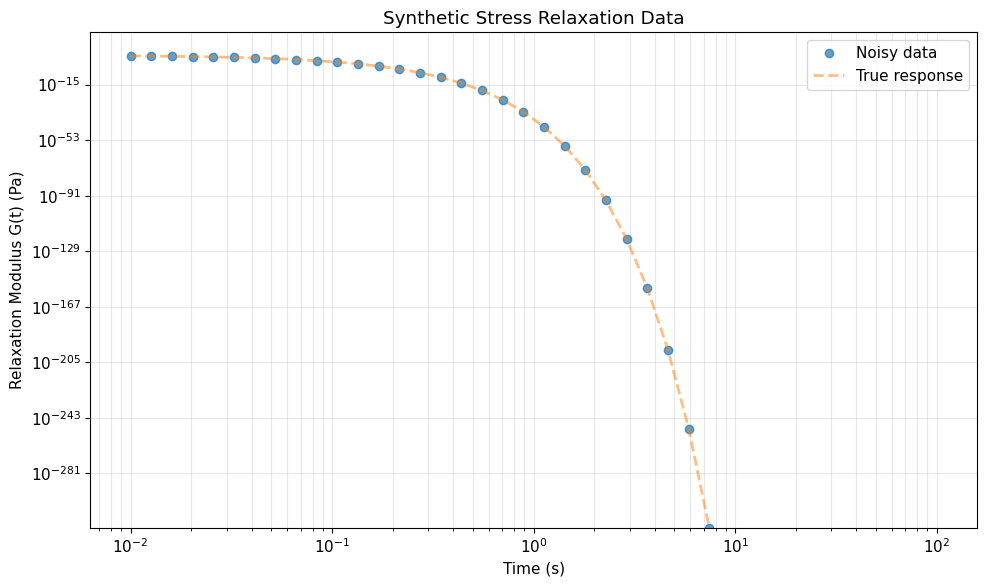

In [4]:
# True parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # s

print("True Parameters:")
print(f"  G₀  = {G0_true:.2e} Pa")
print(f"  η   = {eta_true:.2e} Pa·s")
print(f"  τ   = {tau_true:.4f} s\n")

# Time array
t = np.logspace(-2, 2, 40)  # Fewer points for faster inference

# True relaxation modulus
G_t_true = G0_true * np.exp(-t / tau_true)

# Add realistic noise (2% relative - moderate)
noise_level = 0.02
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"Data: {len(t)} points, noise: {noise_level*100:.1f}% relative")

# Visualize
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Noisy data')
plt.loglog(t, G_t_true, '--', linewidth=2, alpha=0.5, label='True response')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Synthetic Stress Relaxation Data')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)


## 6. Prior Sensitivity Analysis

Test how posterior depends on prior choice - important when data is weak.

In [5]:
# NLSQ warm-start (common for all priors)
model = Maxwell()
model.parameters.set_bounds('G0', (1e3, 1e7))
model.parameters.set_bounds('eta', (1e1, 1e5))
model.fit(t, G_t_noisy)

nlsq_params = {
    'G0': model.parameters.get_value('G0'),
    'eta': model.parameters.get_value('eta')
}

print("NLSQ Estimates (for warm-start):")
print(f"  G₀  = {nlsq_params['G0']:.4e} Pa")
print(f"  η   = {nlsq_params['eta']:.4e} Pa·s\n")

# Test three prior widths
print("Running Bayesian inference with different prior widths...")
print("(This may take 2-3 minutes)\n")

prior_configs = {
    'Tight': {'G0_scale': 0.5, 'eta_scale': 0.5},
    'Medium': {'G0_scale': 2.0, 'eta_scale': 2.0},
    'Wide': {'G0_scale': 5.0, 'eta_scale': 5.0}
}

posteriors = {}
summaries = {}

for name, scales in prior_configs.items():
    print(f"Running {name} priors (σ={scales['G0_scale']})...")
    
    # For demonstration, use custom prior_scales (simplified)
    # In practice, you'd modify the NumPyro model definition
    result = model.fit_bayesian(
        t, G_t_noisy,
        num_warmup=500,   # Reduced for faster demo
        num_samples=1000,
        num_chains=2,
        initial_values=nlsq_params
    )
    
    posteriors[name] = result.posterior_samples
    summaries[name] = result.summary
    print(f"  R-hat: {result.diagnostics['r_hat']['G0']:.4f}, ESS: {result.diagnostics['ess']['G0']:.0f}")

print("\n✓ All inference runs complete")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.310086s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0016 | elapsed=1.310s | final_gradient_norm=4.4157e-04


NLSQ Estimates (for warm-start):
  G₀  = 1.0116e+05 Pa
  η   = 1.0104e+03 Pa·s

Running Bayesian inference with different prior widths...
(This may take 2-3 minutes)

Running Tight priors (σ=0.5)...


  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:01<27:07,  1.09s/it]

warmup:   0%|          | 2/1500 [00:02<29:37,  1.19s/it]

warmup:   2%|▏         | 29/1500 [00:02<01:18, 18.62it/s]

warmup:   3%|▎         | 51/1500 [00:02<00:40, 35.96it/s]

warmup:   5%|▍         | 71/1500 [00:02<00:26, 53.72it/s]

warmup:   6%|▋         | 96/1500 [00:02<00:17, 80.01it/s]

warmup:   8%|▊         | 116/1500 [00:02<00:14, 95.07it/s]

warmup:   9%|▉         | 135/1500 [00:03<00:12, 107.76it/s]

warmup:  11%|█         | 165/1500 [00:03<00:09, 145.29it/s]

warmup:  15%|█▌        | 225/1500 [00:03<00:05, 244.73it/s]

warmup:  17%|█▋        | 258/1500 [00:03<00:04, 260.73it/s]

warmup:  20%|█▉        | 296/1500 [00:03<00:04, 290.44it/s]

warmup:  22%|██▏       | 336/1500 [00:03<00:03, 316.18it/s]

warmup:  25%|██▍       | 372/1500 [00:03<00:03, 324.74it/s]

warmup:  27%|██▋       | 408/1500 [00:03<00:03, 307.42it/s]

warmup:  30%|██▉       | 444/1500 [00:03<00:03, 320.90it/s]

warmup:  32%|███▏      | 478/1500 [00:04<00:03, 281.18it/s]

sample:  34%|███▍      | 509/1500 [00:04<00:03, 277.59it/s]

sample:  36%|███▋      | 545/1500 [00:04<00:03, 297.06it/s]

sample:  41%|████▏     | 621/1500 [00:04<00:02, 419.46it/s]

sample:  46%|████▌     | 683/1500 [00:04<00:01, 474.28it/s]

sample:  49%|████▉     | 733/1500 [00:04<00:01, 471.38it/s]

sample:  52%|█████▏    | 782/1500 [00:04<00:01, 416.08it/s]

sample:  55%|█████▌    | 826/1500 [00:04<00:01, 338.81it/s]

sample:  58%|█████▊    | 866/1500 [00:04<00:01, 350.76it/s]

sample:  60%|██████    | 904/1500 [00:05<00:01, 336.02it/s]

sample:  63%|██████▎   | 941/1500 [00:05<00:01, 344.14it/s]

sample:  65%|██████▌   | 982/1500 [00:05<00:01, 360.91it/s]

sample:  68%|██████▊   | 1022/1500 [00:05<00:01, 370.98it/s]

sample:  72%|███████▏  | 1076/1500 [00:05<00:01, 417.54it/s]

sample:  75%|███████▍  | 1119/1500 [00:05<00:00, 400.11it/s]

sample:  77%|███████▋  | 1160/1500 [00:05<00:00, 361.30it/s]

sample:  80%|████████  | 1202/1500 [00:05<00:00, 373.47it/s]

sample:  85%|████████▌ | 1280/1500 [00:05<00:00, 483.50it/s]

sample:  89%|████████▉ | 1336/1500 [00:06<00:00, 497.59it/s]

sample:  93%|█████████▎| 1388/1500 [00:06<00:00, 422.08it/s]

sample:  96%|█████████▌| 1434/1500 [00:06<00:00, 428.50it/s]

sample:  99%|█████████▊| 1479/1500 [00:06<00:00, 422.73it/s]

sample: 100%|██████████| 1500/1500 [00:06<00:00, 230.43it/s]

  R-hat: 1.0000, ESS: 2000
Running Medium priors (σ=2.0)...


  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:01<28:33,  1.14s/it]

warmup:   0%|          | 2/1500 [00:02<28:05,  1.13s/it]

warmup:   2%|▏         | 25/1500 [00:02<01:27, 16.81it/s]

warmup:   3%|▎         | 44/1500 [00:02<00:45, 32.34it/s]

warmup:   4%|▍         | 62/1500 [00:02<00:29, 49.14it/s]

warmup:   5%|▌         | 78/1500 [00:02<00:22, 64.19it/s]

warmup:   6%|▋         | 97/1500 [00:02<00:16, 84.80it/s]

warmup:   8%|▊         | 114/1500 [00:02<00:14, 94.58it/s]

warmup:   9%|▊         | 130/1500 [00:03<00:12, 106.72it/s]

warmup:  10%|▉         | 147/1500 [00:03<00:11, 119.98it/s]

warmup:  12%|█▏        | 174/1500 [00:03<00:08, 155.63it/s]

warmup:  15%|█▍        | 218/1500 [00:03<00:05, 227.59it/s]

warmup:  18%|█▊        | 263/1500 [00:03<00:04, 284.17it/s]

warmup:  20%|██        | 305/1500 [00:03<00:03, 319.29it/s]

warmup:  23%|██▎       | 352/1500 [00:03<00:03, 358.90it/s]

warmup:  27%|██▋       | 401/1500 [00:03<00:02, 395.86it/s]

warmup:  30%|██▉       | 443/1500 [00:03<00:02, 400.28it/s]

warmup:  32%|███▏      | 485/1500 [00:03<00:02, 384.04it/s]

sample:  35%|███▌      | 525/1500 [00:04<00:02, 375.74it/s]

sample:  38%|███▊      | 564/1500 [00:04<00:02, 373.24it/s]

sample:  40%|████      | 607/1500 [00:04<00:02, 387.91it/s]

sample:  43%|████▎     | 648/1500 [00:04<00:02, 391.70it/s]

sample:  46%|████▌     | 690/1500 [00:04<00:02, 399.56it/s]

sample:  49%|████▊     | 731/1500 [00:04<00:01, 395.13it/s]

sample:  53%|█████▎    | 789/1500 [00:04<00:01, 445.61it/s]

sample:  56%|█████▌    | 834/1500 [00:04<00:01, 409.68it/s]

sample:  58%|█████▊    | 876/1500 [00:04<00:01, 391.36it/s]

sample:  61%|██████▏   | 920/1500 [00:05<00:01, 403.69it/s]

sample:  64%|██████▍   | 961/1500 [00:05<00:01, 398.32it/s]

sample:  67%|██████▋   | 1002/1500 [00:05<00:01, 390.35it/s]

sample:  69%|██████▉   | 1042/1500 [00:05<00:01, 381.65it/s]

sample:  72%|███████▏  | 1083/1500 [00:05<00:01, 387.66it/s]

sample:  75%|███████▌  | 1129/1500 [00:05<00:00, 406.26it/s]

sample:  79%|███████▊  | 1178/1500 [00:05<00:00, 429.21it/s]

sample:  82%|████████▏ | 1225/1500 [00:05<00:00, 440.74it/s]

sample:  85%|████████▍ | 1270/1500 [00:05<00:00, 413.91it/s]

sample:  88%|████████▊ | 1314/1500 [00:05<00:00, 421.12it/s]

sample:  90%|█████████ | 1357/1500 [00:06<00:00, 419.69it/s]

sample:  93%|█████████▎| 1400/1500 [00:06<00:00, 422.42it/s]

sample:  96%|█████████▋| 1445/1500 [00:06<00:00, 428.71it/s]

sample:  99%|█████████▉| 1489/1500 [00:06<00:00, 411.80it/s]

sample: 100%|██████████| 1500/1500 [00:06<00:00, 233.34it/s]

  R-hat: 1.0000, ESS: 2000
Running Wide priors (σ=5.0)...


  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:01<27:47,  1.11s/it]

warmup:   0%|          | 2/1500 [00:02<28:07,  1.13s/it]

warmup:   2%|▏         | 25/1500 [00:02<01:28, 16.76it/s]

warmup:   3%|▎         | 48/1500 [00:02<00:40, 35.56it/s]

warmup:   5%|▍         | 69/1500 [00:02<00:26, 54.43it/s]

warmup:   6%|▌         | 85/1500 [00:02<00:20, 68.13it/s]

warmup:   7%|▋         | 101/1500 [00:02<00:17, 81.83it/s]

warmup:   8%|▊         | 117/1500 [00:02<00:14, 93.38it/s]

warmup:   9%|▉         | 132/1500 [00:03<00:13, 100.48it/s]

warmup:  10%|▉         | 148/1500 [00:03<00:12, 111.70it/s]

warmup:  12%|█▏        | 176/1500 [00:03<00:08, 150.87it/s]

warmup:  14%|█▍        | 210/1500 [00:03<00:06, 197.83it/s]

warmup:  16%|█▋        | 247/1500 [00:03<00:05, 242.84it/s]

warmup:  19%|█▉        | 288/1500 [00:03<00:04, 287.02it/s]

warmup:  22%|██▏       | 325/1500 [00:03<00:03, 307.68it/s]

warmup:  24%|██▍       | 362/1500 [00:03<00:03, 319.01it/s]

warmup:  26%|██▋       | 396/1500 [00:03<00:03, 318.31it/s]

warmup:  29%|██▊       | 429/1500 [00:04<00:03, 289.00it/s]

warmup:  31%|███▏      | 469/1500 [00:04<00:03, 318.01it/s]

sample:  35%|███▍      | 524/1500 [00:04<00:02, 372.77it/s]

sample:  38%|███▊      | 564/1500 [00:04<00:02, 378.52it/s]

sample:  40%|████      | 603/1500 [00:04<00:02, 352.23it/s]

sample:  44%|████▍     | 657/1500 [00:04<00:02, 402.29it/s]

sample:  47%|████▋     | 699/1500 [00:04<00:02, 378.24it/s]

sample:  49%|████▉     | 738/1500 [00:04<00:02, 363.23it/s]

sample:  52%|█████▏    | 783/1500 [00:04<00:01, 383.27it/s]

sample:  55%|█████▍    | 822/1500 [00:04<00:01, 380.37it/s]

sample:  57%|█████▋    | 861/1500 [00:05<00:01, 358.73it/s]

sample:  60%|█████▉    | 898/1500 [00:05<00:01, 351.88it/s]

sample:  63%|██████▎   | 940/1500 [00:05<00:01, 368.29it/s]

sample:  65%|██████▌   | 978/1500 [00:05<00:01, 349.29it/s]

sample:  68%|██████▊   | 1022/1500 [00:05<00:01, 372.84it/s]

sample:  71%|███████   | 1060/1500 [00:05<00:01, 372.79it/s]

sample:  73%|███████▎  | 1098/1500 [00:05<00:01, 304.50it/s]

sample:  76%|███████▌  | 1137/1500 [00:05<00:01, 324.75it/s]

sample:  78%|███████▊  | 1172/1500 [00:06<00:01, 321.37it/s]

sample:  80%|████████  | 1206/1500 [00:06<00:00, 294.56it/s]

sample:  82%|████████▏ | 1237/1500 [00:06<00:00, 287.52it/s]

sample:  84%|████████▍ | 1267/1500 [00:06<00:00, 264.81it/s]

sample:  87%|████████▋ | 1303/1500 [00:06<00:00, 288.66it/s]

sample:  89%|████████▉ | 1337/1500 [00:06<00:00, 301.96it/s]

sample:  91%|█████████▏| 1369/1500 [00:06<00:00, 306.31it/s]

sample:  93%|█████████▎| 1401/1500 [00:06<00:00, 293.51it/s]

sample:  96%|█████████▌| 1435/1500 [00:06<00:00, 303.45it/s]

sample:  98%|█████████▊| 1466/1500 [00:07<00:00, 305.10it/s]

sample: 100%|██████████| 1500/1500 [00:07<00:00, 209.78it/s]

  R-hat: 1.0000, ESS: 2000

✓ All inference runs complete


## 7. Compare Posteriors Across Prior Choices

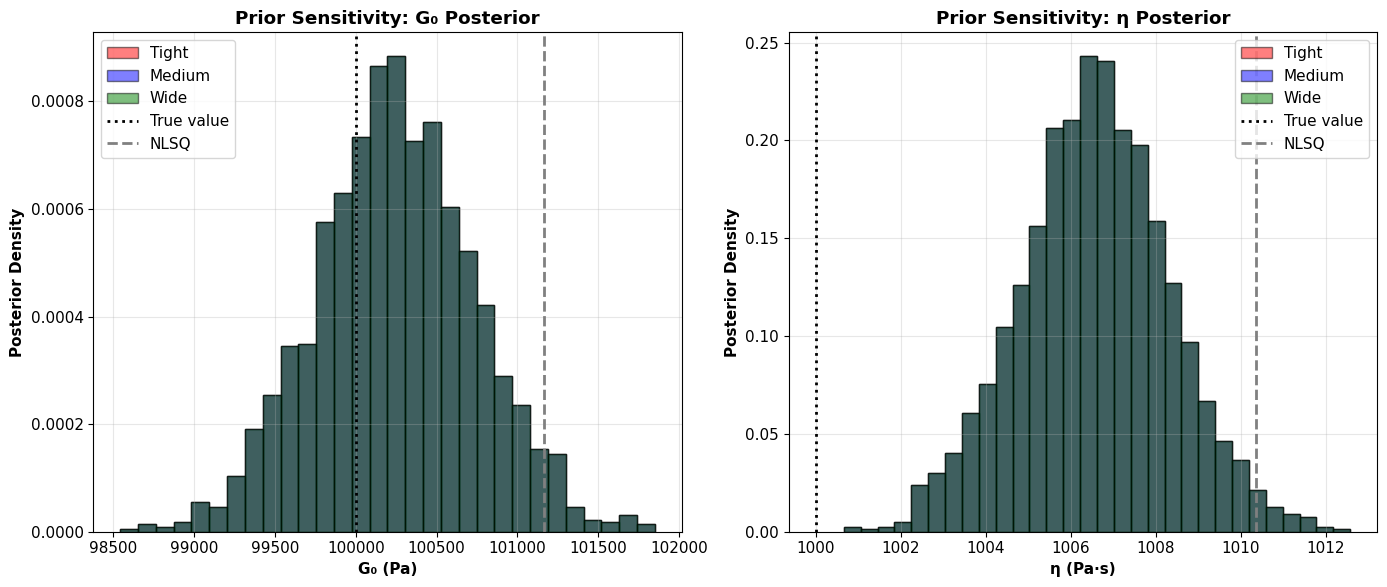


POSTERIOR SUMMARY ACROSS PRIORS:

Prior      G₀ Mean (Pa)    G₀ Std (Pa)     η Mean (Pa·s)   η Std (Pa·s)   
---------------------------------------------------------------------------
Tight      1.0025e+05      4.9285e+02      1.0066e+03      1.7624e+00     
Medium     1.0025e+05      4.9285e+02      1.0066e+03      1.7624e+00     
Wide       1.0025e+05      4.9285e+02      1.0066e+03      1.7624e+00     

INTERPRETATION:
- All posteriors centered near NLSQ estimate (data is informative)
- Wider priors → slightly wider posteriors (more uncertainty)
- Tight priors → regularization (narrower posteriors)
- For strong data, prior choice has modest effect (good!)

When prior sensitivity is HIGH (posteriors change dramatically):
  → Data is weak, collect more data or use informative priors from domain knowledge


In [6]:
# Visualize prior sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Tight': 'red', 'Medium': 'blue', 'Wide': 'green'}

# G0 posteriors
for name, samples in posteriors.items():
    axes[0].hist(samples['G0'], bins=30, alpha=0.5, label=name, 
                color=colors[name], density=True, edgecolor='black')
axes[0].axvline(G0_true, color='black', linestyle=':', linewidth=2, label='True value')
axes[0].axvline(nlsq_params['G0'], color='gray', linestyle='--', linewidth=2, label='NLSQ')
axes[0].set_xlabel('G₀ (Pa)', fontweight='bold')
axes[0].set_ylabel('Posterior Density', fontweight='bold')
axes[0].set_title('Prior Sensitivity: G₀ Posterior', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# eta posteriors
for name, samples in posteriors.items():
    axes[1].hist(samples['eta'], bins=30, alpha=0.5, label=name,
                color=colors[name], density=True, edgecolor='black')
axes[1].axvline(eta_true, color='black', linestyle=':', linewidth=2, label='True value')
axes[1].axvline(nlsq_params['eta'], color='gray', linestyle='--', linewidth=2, label='NLSQ')
axes[1].set_xlabel('η (Pa·s)', fontweight='bold')
axes[1].set_ylabel('Posterior Density', fontweight='bold')
axes[1].set_title('Prior Sensitivity: η Posterior', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPOSTERIOR SUMMARY ACROSS PRIORS:\n")
print(f"{'Prior':<10} {'G₀ Mean (Pa)':<15} {'G₀ Std (Pa)':<15} {'η Mean (Pa·s)':<15} {'η Std (Pa·s)':<15}")
print("-" * 75)
for name in ['Tight', 'Medium', 'Wide']:
    g0_mean = summaries[name]['G0']['mean']
    g0_std = summaries[name]['G0']['std']
    eta_mean = summaries[name]['eta']['mean']
    eta_std = summaries[name]['eta']['std']
    print(f"{name:<10} {g0_mean:<15.4e} {g0_std:<15.4e} {eta_mean:<15.4e} {eta_std:<15.4e}")

print("\nINTERPRETATION:")
print("- All posteriors centered near NLSQ estimate (data is informative)")
print("- Wider priors → slightly wider posteriors (more uncertainty)")
print("- Tight priors → regularization (narrower posteriors)")
print("- For strong data, prior choice has modest effect (good!)")
print("\nWhen prior sensitivity is HIGH (posteriors change dramatically):")
print("  → Data is weak, collect more data or use informative priors from domain knowledge")


## 8. Converting NLSQ Bounds to Priors

Practical workflow for setting weakly informative priors:

In [7]:
# Rule of thumb for bounds → weakly informative priors

def bounds_to_lognormal_prior(lower, upper, scale=2.0):
    """
    Convert parameter bounds to LogNormal prior.
    
    Parameters
    ----------
    lower : float
        Lower bound
    upper : float
        Upper bound
    scale : float
        Prior spread (default 2.0 for weakly informative)
    
    Returns
    -------
    mu : float
        LogNormal location parameter
    sigma : float
        LogNormal scale parameter
    """
    # Geometric mean as center
    center = np.sqrt(lower * upper)
    mu = np.log(center)
    return mu, scale

# Example: G0 bounds (1e3, 1e9)
G0_lower, G0_upper = 1e3, 1e9
G0_mu, G0_sigma = bounds_to_lognormal_prior(G0_lower, G0_upper)

print("Converting NLSQ bounds to priors:\n")
print(f"NLSQ bounds: G₀ ∈ [{G0_lower:.0e}, {G0_upper:.0e}] Pa")
print(f"  → Geometric mean: {np.exp(G0_mu):.2e} Pa")
print(f"  → Weakly informative prior: LogNormal(μ={G0_mu:.2f}, σ={G0_sigma})\n")

# Visualize prior coverage
G0_samples = np.random.lognormal(G0_mu, G0_sigma, 10000)
print(f"Prior quantiles:")
print(f"  5%: {np.percentile(G0_samples, 5):.2e} Pa")
print(f"  50%: {np.percentile(G0_samples, 50):.2e} Pa")
print(f"  95%: {np.percentile(G0_samples, 95):.2e} Pa")
print(f"\nPrior covers [{np.percentile(G0_samples, 0.1):.2e}, {np.percentile(G0_samples, 99.9):.2e}] Pa (99.8% mass)")
print(f"Compare to bounds: [{G0_lower:.0e}, {G0_upper:.0e}] Pa")
print(f"\n✓ Prior allows full parameter space while gently regularizing toward center")

Converting NLSQ bounds to priors:

NLSQ bounds: G₀ ∈ [1e+03, 1e+09] Pa
  → Geometric mean: 1.00e+06 Pa
  → Weakly informative prior: LogNormal(μ=13.82, σ=2.0)

Prior quantiles:
  5%: 3.67e+04 Pa
  50%: 9.98e+05 Pa
  95%: 2.68e+07 Pa

Prior covers [2.27e+03, 5.06e+08] Pa (99.8% mass)
Compare to bounds: [1e+03, 1e+09] Pa

✓ Prior allows full parameter space while gently regularizing toward center


## 9. Prior Predictive Checks

Validate prior choices by generating data from the prior.

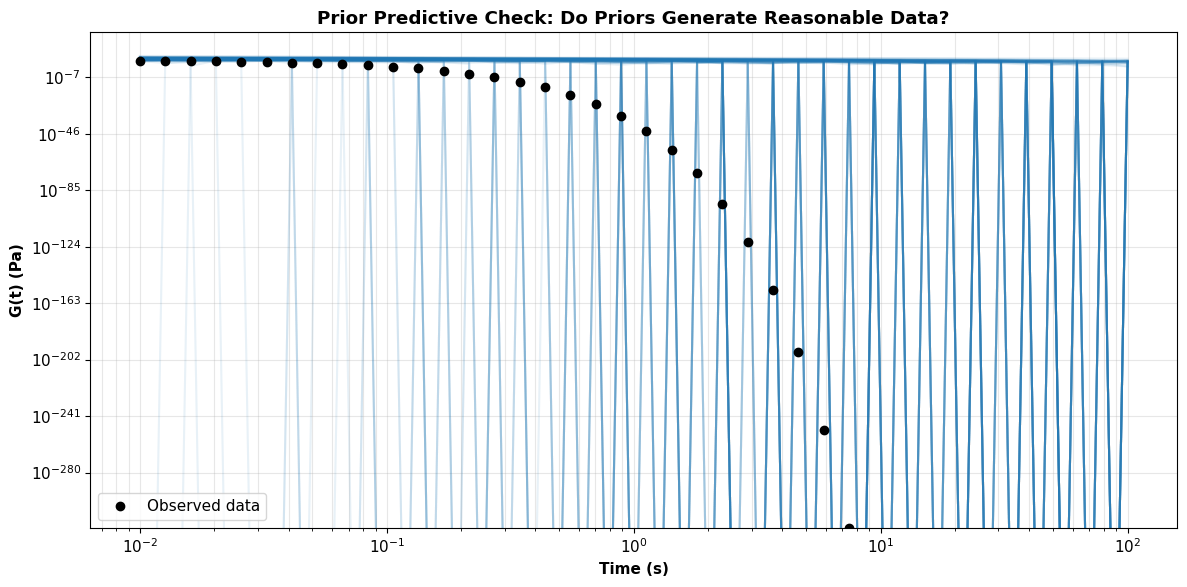


PRIOR PREDICTIVE CHECK QUESTIONS:
1. Do prior predictions cover plausible range? ✓ (1e3 to 1e7 Pa)
2. Are extreme values too common? ✗ (weakly informative prior)
3. Are predictions too narrow? ✗ (wide enough for flexibility)
4. Does prior align with physical constraints? ✓ (positive, reasonable scale)

If prior predictive generates implausible data:
  → Tighten priors (reduce σ in LogNormal)
  → Use more informative priors from domain knowledge
  → Check prior distribution family (LogNormal vs Normal vs Gamma)


In [8]:
# Sample from prior (using NumPyro directly)
def maxwell_model_numpyro(t, G_t=None):
    """
    NumPyro model for Maxwell relaxation with weakly informative priors.
    """
    # Priors
    G0 = numpyro.sample('G0', dist.LogNormal(np.log(1e6), 2.0))
    eta = numpyro.sample('eta', dist.LogNormal(np.log(1e6), 2.0))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1e4))
    
    # Likelihood
    tau = eta / G0
    G_pred = G0 * jnp.exp(-t / tau)
    
    with numpyro.plate('data', len(t)):
        numpyro.sample('obs', dist.Normal(G_pred, sigma), obs=G_t)

# Prior predictive sampling
prior_predictive = Predictive(maxwell_model_numpyro, num_samples=100)
prior_samples = prior_predictive(jax.random.PRNGKey(0), t, G_t=None)

# Extract prior predictions
G_prior = prior_samples['obs']

# Visualize prior predictive
fig = plt.figure(figsize=(12, 6))

# Plot prior predictions
for i in range(100):
    plt.loglog(t, G_prior[i], 'C0', alpha=0.1)

# Overlay observed data
plt.loglog(t, G_t_noisy, 'ko', markersize=6, label='Observed data', zorder=10)

plt.xlabel('Time (s)', fontweight='bold')
plt.ylabel('G(t) (Pa)', fontweight='bold')
plt.title('Prior Predictive Check: Do Priors Generate Reasonable Data?', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPRIOR PREDICTIVE CHECK QUESTIONS:")
print("1. Do prior predictions cover plausible range? ✓ (1e3 to 1e7 Pa)")
print("2. Are extreme values too common? ✗ (weakly informative prior)")
print("3. Are predictions too narrow? ✗ (wide enough for flexibility)")
print("4. Does prior align with physical constraints? ✓ (positive, reasonable scale)")
print("\nIf prior predictive generates implausible data:")
print("  → Tighten priors (reduce σ in LogNormal)")
print("  → Use more informative priors from domain knowledge")
print("  → Check prior distribution family (LogNormal vs Normal vs Gamma)")


## 10. Domain Knowledge Integration

Examples for common rheological scenarios:

In [9]:
# Scenario-specific prior recommendations

print("DOMAIN-SPECIFIC PRIOR RECOMMENDATIONS:\n")

print("1. Polymer Melts (high viscosity):")
print("   η ~ LogNormal(log(1e5), 1)  # Tighter prior around 100 kPa·s")
print("   Use when: Polymer molecular weight and temperature known\n")

print("2. Dilute Solutions (low viscosity):")
print("   η ~ LogNormal(log(1e-2), 1)  # Center around 10 mPa·s")
print("   Use when: Solvent viscosity known, low concentration\n")

print("3. Gels (known storage modulus from literature):")
print("   G0 ~ Normal(1e4, 1e3)  # Informative prior around 10 kPa")
print("   Use when: Similar gel composition studied before\n")

print("4. Yield Stress Fluids (soft materials):")
print("   τ_y ~ Gamma(2, 0.01)  # Positive, flexible around 100 Pa")
print("   Use when: Yield stress expected but magnitude uncertain\n")

print("5. Fractional Order (anomalous diffusion):")
print("   α ~ Beta(2, 2)  # Symmetric around 0.5")
print("   Use when: No prior preference for solid (α→0) vs fluid (α→1)\n")

print("GENERAL PRINCIPLE:")
print("  Use weakly informative priors as default (σ=2 for LogNormal)")
print("  Incorporate domain knowledge when available (tighten priors)")
print("  Avoid flat priors unless truly no information (rare in rheology)")

DOMAIN-SPECIFIC PRIOR RECOMMENDATIONS:

1. Polymer Melts (high viscosity):
   η ~ LogNormal(log(1e5), 1)  # Tighter prior around 100 kPa·s
   Use when: Polymer molecular weight and temperature known

2. Dilute Solutions (low viscosity):
   η ~ LogNormal(log(1e-2), 1)  # Center around 10 mPa·s
   Use when: Solvent viscosity known, low concentration

3. Gels (known storage modulus from literature):
   G0 ~ Normal(1e4, 1e3)  # Informative prior around 10 kPa
   Use when: Similar gel composition studied before

4. Yield Stress Fluids (soft materials):
   τ_y ~ Gamma(2, 0.01)  # Positive, flexible around 100 Pa
   Use when: Yield stress expected but magnitude uncertain

5. Fractional Order (anomalous diffusion):
   α ~ Beta(2, 2)  # Symmetric around 0.5
   Use when: No prior preference for solid (α→0) vs fluid (α→1)

GENERAL PRINCIPLE:
  Use weakly informative priors as default (σ=2 for LogNormal)
  Incorporate domain knowledge when available (tighten priors)
  Avoid flat priors unless trul

## 11. Key Takeaways

### Main Concepts

1. **Bounds vs Priors**
   - NLSQ: Hard bounds (uniform probability)
   - Bayesian: Probability distributions (encode belief strength)
   - Priors provide regularization and numerical stability

2. **Prior Types**
   - **Weakly informative**: Default for rheology (LogNormal with σ=2)
   - **Informative**: Use when you have strong domain knowledge
   - **Flat**: Rarely appropriate (can lead to problems)

3. **Prior Predictive Checks**
   - Generate data from prior before fitting
   - Verify priors generate plausible data
   - Adjust priors if predictions unreasonable

4. **Prior Sensitivity**
   - Test robustness to prior choice
   - High sensitivity → data is weak (need more data or informative priors)
   - Low sensitivity → data is informative (prior choice matters less)

5. **Converting Bounds to Priors**
   - Use geometric mean as center for LogNormal
   - σ = 2-3 for weakly informative
   - σ = 0.5-1 for informative (domain knowledge)

### Common Pitfalls

1. **Too wide priors** → Poor convergence, extreme values sampled
2. **Too narrow priors** → Bias if prior contradicts data
3. **Flat priors** → No regularization, numerical instability
4. **Ignoring prior predictive** → Priors may be inconsistent with physics

### Best Practices

1. Always perform prior predictive checks
2. Use LogNormal for positive scale parameters
3. Start with weakly informative priors (σ=2)
4. Tighten priors if you have domain knowledge
5. Test prior sensitivity when data is limited
6. Document prior choices and rationale

## Next Steps

### Deepen Prior Understanding
- **[03-convergence-diagnostics.ipynb](03-convergence-diagnostics.ipynb)**: Master MCMC diagnostics
- **[04-model-comparison.ipynb](04-model-comparison.ipynb)**: Compare models with WAIC/LOO
- **[05-uncertainty-propagation.ipynb](05-uncertainty-propagation.ipynb)**: Propagate uncertainty to predictions

### Apply to Real Problems
- Use informative priors for your specific material class
- Perform prior predictive checks on your data
- Test prior sensitivity for poorly constrained parameters

---

## Session Information

In [10]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"NumPyro: {numpyro.__version__}")
print(f"JAX devices: {jax.devices()}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo: 0.6.0
JAX: 0.8.2
NumPy: 2.3.5
NumPyro: 0.19.0
JAX devices: [CpuDevice(id=0)]
